# Technical test for the data science internship @Hyperlex

In [353]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [426]:
import os
import json
import numpy as np
import pandas as pd

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# from nltk.tokenize import RegexpTokenizer , word_tokenize
# from nltk.stem.snowball import SnowballStemmer
# from nltk.corpus import stopwords
import spacy
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence

import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

ModuleNotFoundError: No module named 'gensim'

In [355]:
#!find . -iname *checkpoint* -type d -exec rm -r {} +  

In [356]:
rootdir = 'dataset'
json_files = [os.path.join(dirpath, file) for dirpath,_,files in os.walk(rootdir) for file in files if file.endswith('json')]

contracts = []
for file in json_files:
    with open(file) as f:
        contracts.append(json.load(f)['clauses'][1:])  # starting from one to skip the summary since they contain different informations 
                                                  # and could affect the clustering
            
contracts_df = pd.DataFrame(contracts)

In [357]:
# adding number of clauses colomn in contracts_df
contracts_df['num_clauses'] = contracts_df.notna().sum(axis=1)

Text(0,0.5,'number of clauses')

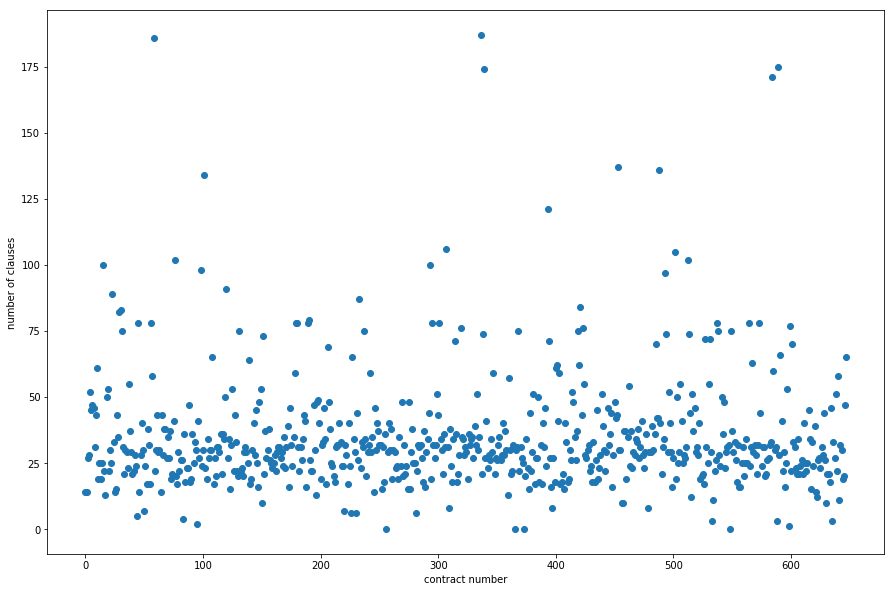

In [358]:
plt.figure(figsize=(15,10))
plt.scatter([range(contracts_df.shape[0])],contracts_df['num_clauses'])
plt.xlabel('contract number')
plt.ylabel('number of clauses')

In [409]:
contracts_df[contracts_df['num_clauses']<1]

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,num_clauses
256,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,0
365,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,0
373,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,0
548,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,0


In [406]:
json_files[548]

'dataset\\statuts mjpm_20160113095057-OCR_OCR-pdfa\\statuts mjpm_20160113095057-OCR_OCR-pdfa.json'

We can observe that we have some outliers in the corpus:
* contracts with "too many" clauses
* contracts with almost no clauses

after observing the json files, I deemed it fit to just drop them (badly parsed)

In [359]:
#pattern = re.compile('(?i)article\s*\d+.*article\s*\d+')
#contracts_df.apply(lambda x: x.str.contains(pattern, regex=True), axis=1)

In [375]:
clauses_df = contracts_df.drop('num_clauses',axis=1).values.flatten()
clauses_df = clauses_df[clauses_df != np.array(None)]
clauses_df = pd.DataFrame(clauses_df)
clauses_df.describe()

,0
count,22796
unique,18992
top,"ARTICLE 10 FORME, CESSION ET TRANSMISSION DES ..."
freq,31


Although the duplicates won't affect the averaging used to find the kMeans centroids (for kmeans algorithm), I still decided to remove them because I only need unique descriptions to perform the clustering. Note that dropping duplicates will still keep one of those entries in the set.

In [377]:
clauses_df.drop_duplicates(inplace=True)
clauses_df.index = range(len(clauses_df.index)) # faster than reset_index
clauses_df.describe()

,0
count,18992
unique,18992
top,ARTICLE 21. LIQUIDATION
freq,1


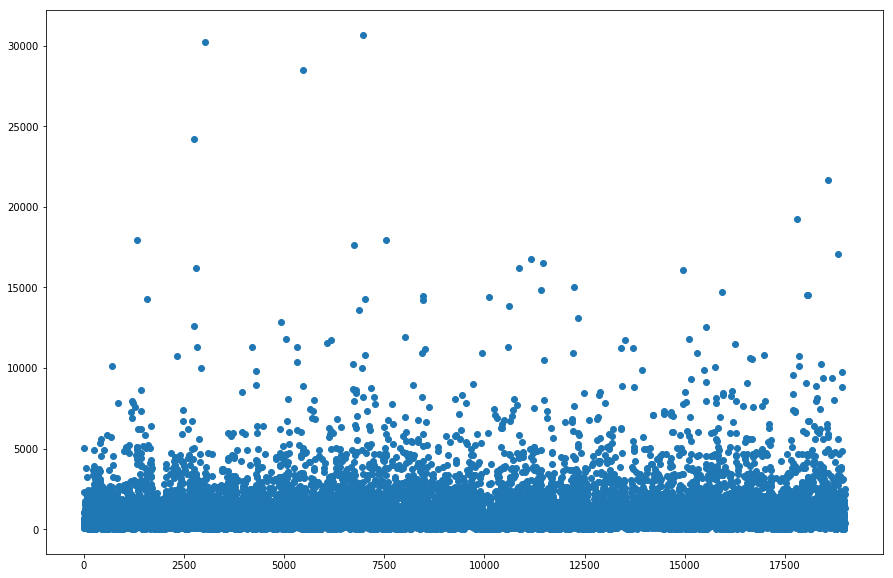

In [380]:
clauses_lengths = [len(clause[0]) for clause in clauses_df.values]
plt.figure(figsize=(15,10))
plt.scatter([range(len(clauses_lengths))], clauses_lengths)

In [400]:
mask = clauses_df[0].str.len() > 20000
clauses_df[mask]

,0
2743,ARTICLE 5 La durée DUREE de la Société reste f...
3034,ARTICLE 5 DUREE La durée de la Société est fix...
5463,ARTICLE 9 LIBERATION DES ACTIONS) Lors de la c...
6980,5.3 Droit préférentiel de souscription En cas ...
18563,"ARTICLE 11 SOUSCRIPTION, LIBERATION ET REPRESE..."


## Pre-processing pipeline :

before editing the data, we can extract the "labels" of each clause (for evaluation purposes)
1. **Tokenization** (nltk word tokenizer should be good)  . check out spacy as well  
2. possible way to clean data :
    * delete all numerical and alphanumerical words
    * delete "ARTICLE x.x"
    * delete punctuation
3. **lower case**
4. explore the possibility of combining some "special words" into n-grams
5. **lemmatization**
6. **stop words**
7. **Save your work**

In [419]:
%%time
nlp = spacy.load('fr')

Wall time: 10.2 s


In [422]:
clauses_df[0].values[0]

'ARTICLE 1 Forme La société est une entreprise unipersonnelle à responsabilité limitée, qui sera régie par les articles L 223 1 et suivants du Code de Commerce et par les présents statuts. Elle fonctionne indifféremment sous la même forme avec un ou plusieurs associés.'

In [424]:
parsed = nlp(clauses_df[0].values[0])
parsed

ARTICLE 1 Forme La société est une entreprise unipersonnelle à responsabilité limitée, qui sera régie par les articles L 223 1 et suivants du Code de Commerce et par les présents statuts. Elle fonctionne indifféremment sous la même forme avec un ou plusieurs associés.

In [425]:
for num, entity in enumerate(parsed.ents):
    print ('Entity {}:'.format(num + 1), entity, '-', entity.label_)
    print ('')

Entity 1: ARTICLE - ORG

Entity 2: Code de Commerce - MISC



In [ ]:
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
stopWords = set(stopwords.words('french')).union(punc)

words = word_tokenize(data)
wordsFiltered = []
 
for w in words:
    if w not in stopWords:
        wordsFiltered.append(w)
print(wordsFiltered)

## Feature engineering

* **TF-IDF** or **TF** depending on the "clustering" model (NMF , LDA, Kmeans, LSI ...)
* if possible find some legal words embeddings for later semantic analysis

## Modeling
* LDA
* NMF
* Kmeans

## Evaluation and qualitative analysis
* look for possible measures and scores (coherence measure)

## Semantic analysis to extraction variation inside a cluster
* use Word embeddings

The problem here is how to measure similarity between documents (clause). one way to do this is to average the word embeddings forming the document into one single vector (**doc embedding**). 

the similarity measure would probably be the **cosine distance**